# Autoencoder for anomaly detection

An autoencoder is a special type of deep learning architecture used to learn representations of data based solely on descriptive features. The representation, which is a transformation of the raw data, is learned with the objective to reconstruct the original data the most accurately. This representation learning strategy can be used for dimensionality reduction, denoising, or even generative applications.

An autoencoder can be divided into two parts:

- The encoder part that maps the input into the representation, also referred to as the "code" or the "bottleneck".
- The decoder that maps the code to a reconstruction of the input.

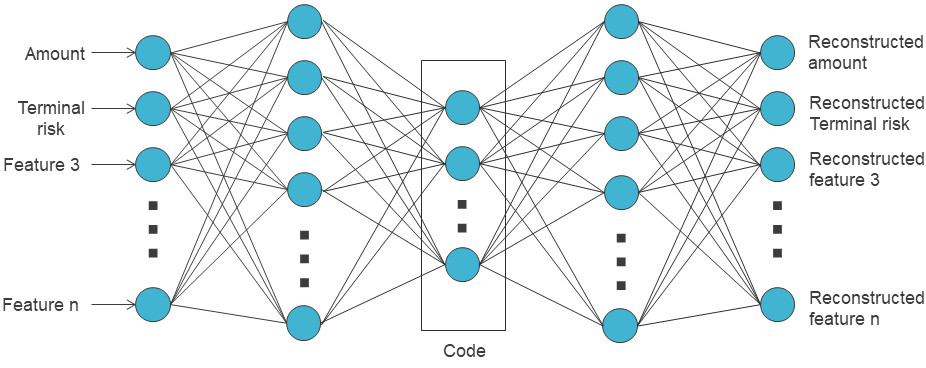



The encoder and decoder can have complex architectures line RNN, CNN but in simple terms, they are only multi layered NN. The dimension of the code which is the input to the decoder can be less than that of the input dimension to reduce dimensionality and is fixed aribitrarily. The dimension of the output of the decoder is the same as the input of the encoder because its purpose is to reconstruct the input. 

The architecture is generally trained end-to-end by optimizing the input reconstruction, i.e. by minimizing a loss that measures a difference between the model's output and the input. It can be trained with any unlabeled data. 
Autoencoders can be used as techniques for unsupervised or semi-supervised anomaly detection, which led them to be used multiple times for credit card fraud detection.

 ## Anomaly detection
 Anomalies in credit card fraud detection can be rare events or unexpected bursts in the activity of a single cardholder behavior, or specific patterns, not necessarily rare, in the global consumers' behavior. Rare events or outliers can be detected with unsupervised techniques that learn the normality and which are able to estimate discrepancy to this normality. But detection of other types of anomaly can require supervised techniques with proper training. 
Therefore, one can think of three types of anomaly detection techniques:

- Supervised techniques, that require annotations on data that consist of two classes, "normal" (or "genuine") and "abnormal" (or "fraud"), and they learn to discriminate between those classes.
- Unsupervised techniques that aim at detecting anomalies by modeling the majority behavior and considering it as "normal". Then they detect the "abnormal" or fraudulent behavior by searching for examples that do not fit well to the normal behavior.
- Semi-supervised techniques that are in between the two above cases and that can learn from both unlabeled and labeled data to detect fraudulent transactions.


An autoencoder can be used to model the normal behavior of data and detect outliers using the reconstruction error as an indicator. In particular, one way to do so is to train it to globally reconstruct transactions in a dataset. The normal trend that is observed in the majority of transactions will be better approximated than rare events. Therefore, the reconstruction error of "normal" data will be lower than the reconstruction error of outliers.

An autoencoder can therefore be considered as an unsupervised technique for fraud detection. In this section, we will implement and test it for both semi-supervised and unsupervised fraud detection.

Let us first start by importing all the necessary libraries and functions and retrieving the simulated data.

In [2]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   352k      0 --:--:-- --:--:-- --:--:--  352k
Cloning into 'simulated-data-transformed'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 189 (delta 0), reused 3 (delta 0), pack-reused 186
Receiving objects: 100% (189/189), 70.08 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (184/184), done.


## Data Loading


In [3]:
DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: user 299 ms, sys: 354 ms, total: 653 ms
Wall time: 662 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [27]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

## Autoencoder implementation

In [28]:
# Import necessary libraries
import torch

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

#To ensure reproducibility, a random seed will be fixed
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)



Selected device is cuda


Let us also convert our features and labels into torch tensors.




In [29]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

The autoencoder has the same input as the baseline models but a
different output. Instead of the fraud/genuine label, its target will be the same as the input. Therefore, the experiments here will relay on Dataset: FraudDatasetUnsupervised, which only receives the descriptive features of the transaction x and returns it as both input and output.
We will create data geneartors for both train and validation data.

In [32]:
class FraudDatasetUnsupervised(torch.utils.data.Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [33]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

This Dataset can also be turned into DataLoaders with the function prepare_generators.

In [34]:
def prepare_generators(training_set,valid_set,batch_size=64):
    
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}
    
    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)
    
    return training_generator,valid_generator

In [35]:
training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)


The second and main element in our deep learning pipeline is the model/module. Since our data are tabular and each sample is a vector, we will resort to a regular feed-forward autoencoder. Its output has as many neurons as the input, with linear activations. An intermediate layer, before the representation layer, will also be considered such that the overall succession of layers with their dimensions (input_dim, output_dim) are the following:

- A first input layer with ReLu activation (input_size, intermediate_size)
- A second layer with ReLu activation (intermediate_size, code_size)
- A third layer with ReLu activation (code_size, intermediate_size)
- An output layer with linear activation (intermediate_size, input_size)

In [12]:
class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

The third element of our pipeline is the optimization problem. The underlying machine learning problem is a regression here, where the predicted and expected outputs are real-valued variables. Therefore, the most adapted loss function is the mean squared error torch.nn.MSELoss.

In [13]:
criterion = torch.nn.MSELoss().to(DEVICE)


## Using the autoencoder for unsupervised fraud detection

The autoencoder's goal is to predict the input from the input. Therefore, one cannot directly use its prediction for fraud detection. Instead, the idea is to use its reconstruction error, i.e. the mean squared error (MSE) between the input and the output, as an indicator for fraud likelihood. The higher the error, the higher the risk score. Therefore, the reconstruction error can be considered as a predicted fraud risk score, and its relevance can be directly measured with any threshold-free metric.

For that purpose, let us define a function per_sample_mse that will compute the MSE of a model for each sample provided by a generator:

In [14]:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses


Here is what happens when trying it on the validation samples with an untrained autoencoder. Let us use 100 neurons in the intermediate layer and 20 neurons in the representation layer:

In [15]:
seed_everything(SEED)
model = SimpleAutoencoder(x_train.shape[1], 100, 20).to(DEVICE)
losses = per_sample_mse(model, valid_generator)


In [16]:
#Before training it, here are the loss values for the first five samples, and the overall average loss.

print(losses[0:5])
print(np.mean(losses))

[0.6754841, 0.7914626, 1.1697073, 0.807015, 1.258897]
0.9325166


With random weights in its layers, the untrained autoencoder is rather bad at reconstruction. It has a squared error of 0.93 on average for the standardized transaction variables.

Let us now train it and see how this evolves. The process is the following:

- Prepare the generators.
- Define the criterion.
- Instantiate the model.
- Perform several optimization loops (with an optimization technique like gradient descent with Adam) on the training data.
- Stop optimization with early stopping using validation data.

All of these steps are implemented using function training_loop.

Let us implement an early stopping strategy. The idea is to detect overfitting, i.e. when validation error starts increasing, and stop the training process. Sometimes, the validation error might increase at a given epoch, but then decrease again. For that reason, it is important to also consider a patience parameter, i.e. a number of iterations for which the training process waits in order to make sure that the error is definitely increasing.

In [42]:

def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss 

In [43]:
class EarlyStopping:
    
    def __init__(self, patience=2, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.Inf
    
    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            if self.verbose:
                print("New best score:", current_score)
        else:
            self.counter+=1
            if self.verbose:
                print(self.counter, " iterations since best score.")
                
        return self.counter <= self.patience  

In [44]:
def training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=100,apply_early_stopping=True,patience=2,verbose=False):
    #Setting the model in training mode
    model.train()

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)
    
    all_train_losses = []
    all_valid_losses = []
    
    #Training loop
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(x_batch)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_batch)
            # Backward pass
            loss.backward()
            optimizer.step()   
            train_loss.append(loss.item())
        
        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        
        #evaluating the model on the test set after each epoch    
        valid_loss = evaluate_model(model,valid_generator,criterion)
        
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                if verbose:
                    print("Early stopping")
                break
        
    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses


In [47]:
# Define generator,model,criterion and optimizer
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [48]:
#Perform training, giving max epochs as 75
model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=75,
                                                                        verbose=True)


Epoch 0: train loss: 0.44572424150675705
valid loss: 0.11789110732860253
New best score: 0.11789110732860253

Epoch 1: train loss: 0.0844522707082374
valid loss: 0.04473799423523288
New best score: 0.04473799423523288

Epoch 2: train loss: 0.03813447226212853
valid loss: 0.028129174045281983
New best score: 0.028129174045281983

Epoch 3: train loss: 0.0239454295537853
valid loss: 0.0168397196655065
New best score: 0.0168397196655065

Epoch 4: train loss: 0.013856802930802563
valid loss: 0.00960458055535545
New best score: 0.00960458055535545

Epoch 5: train loss: 0.007683097787983146
valid loss: 0.005340767848493705
New best score: 0.005340767848493705

Epoch 6: train loss: 0.005278765761701258
valid loss: 0.004115466984202627
New best score: 0.004115466984202627

Epoch 7: train loss: 0.0040532071828970374
valid loss: 0.0031356977306489574
New best score: 0.0031356977306489574

Epoch 8: train loss: 0.00307789881759097
valid loss: 0.002502913639850182
New best score: 0.0025029136398501

Least losses with a patience of 2 is acheived here in 51 epochs.

In [49]:
# check the validation loss
losses = per_sample_mse(model, valid_generator)
print(losses[0:5])
print(np.mean(losses))

[3.323677e-05, 2.8500328e-05, 3.649523e-05, 4.560114e-05, 3.5764606e-05]
6.9989146e-05


In [51]:
print('input features for 1 sample:',x_train[0])
print('Predicted features for 1 sample:',model(x_train[0].to(DEVICE)))

input features for 1 sample: tensor([-0.1323, -0.6306,  2.1808, -0.3003,  0.1241, -1.6917,  0.5035, -1.6630,
        -0.0482, -0.9810, -0.0816, -1.9895, -0.1231, -0.9719, -0.1436])
Predicted features for 1 sample: tensor([-0.1360, -0.6270,  2.1803, -0.2966,  0.1197, -1.6987,  0.5019, -1.6771,
        -0.0490, -0.9763, -0.0749, -1.9800, -0.1181, -0.9696, -0.1373],
       device='cuda:0', grad_fn=<AddBackward0>)


When trained, the autoencoder is much better at encoding/decoding a transaction. It now obtains a very low squared error (0.00006) on average for our standardized transaction variables. Moreover, the example above (with x_train[0]) illustrates how well the reconstructed transaction is similar to the input transaction.



To answer the question whether frauds are less well reconstructed than genuine transactions, such that reconstruction error can be used as an indicator of fraud risk, we will compute the average squared error for fraudulent and genuine transactions separately.

In [62]:
genuine_losses = np.array(losses)[y_valid.cpu().numpy() == 0]
fraud_losses = np.array(losses)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.0013612186
Average genuine reconstruction error: 6.168171e-05


It appears that frauds are indeed less well reconstructed than genuine transactions, which is very encouraging. This shows that this autoencoder is a very promising way to find fraud/outlier transactions.

Let us now compute the AUC ROC, the average precision, and card precision@100 on the validation set by considering the reconstruction error as a predicted fraud score.



In [63]:
predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.84,0.162,0.2


Although less accurate than the supervised techniques covered before, this unsupervised method leads to encouraging results and is much more accurate than the random classifier.

Finding:

Autoencoders are part of the large deep learning models family. Their goal is to learn representations to reconstruct descriptive variables, so they have been widely used for unsupervised learning problems. Anomaly detection, and in particular fraud detection, can be tackled with unsupervised techniques.

Here we used reconstruction error of autoencoder as an indicator for fraud risk. Used solely (unsupervised method), it detects data points that are away from the rest of the distribution, which allows detecting many frauds but also introduces a lot of false alerts (e.g. genuine transactions that have rare characteristics). Therefore, it obtains a decent AUC ROC but low precision-based metrics.